# Text Classification using TF-IDF and SGDClassifier

This notebook demonstrates text classification using:
1.  **Feature Engineering**: TF-IDF (Term Frequency-Inverse Document Frequency).
2.  **Classification Algorithm**: SGDClassifier (Stochastic Gradient Descent), which is efficient for large-scale learning and often used for text classification (linear SVM or logistic regression).

Target Label: `Label`
Content: `Cleaned_Content`

Step 1: Loading Data...
Classes: ["Alzheimer's Disease" 'Frontotemporal Dementia' 'Lewy Body Dementia'
 "Parkinson's Disease" 'Vascular Dementia']
Step 2: Extracting TF-IDF Features...
Feature Matrix Shape: (800, 5000)

Step 3: Training SGD Classifier...
Running 10-Fold Cross-Validation...
Mean CV Accuracy: 0.5388 (+/- 0.0356)

Step 4: Plotting Learning Curves...


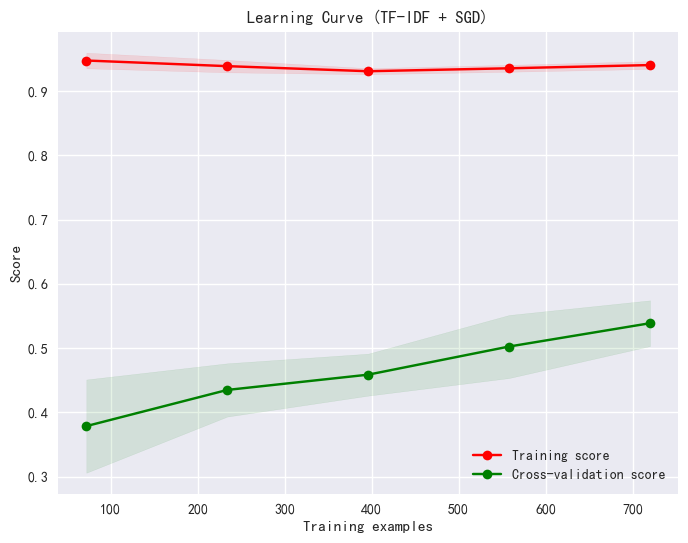


--- Classification Report ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.74      0.62      0.68        40
Frontotemporal Dementia       0.75      0.60      0.67        40
     Lewy Body Dementia       0.46      0.68      0.55        40
    Parkinson's Disease       0.62      0.60      0.61        40
      Vascular Dementia       0.61      0.55      0.58        40

               accuracy                           0.61       200
              macro avg       0.63      0.61      0.61       200
           weighted avg       0.63      0.61      0.61       200



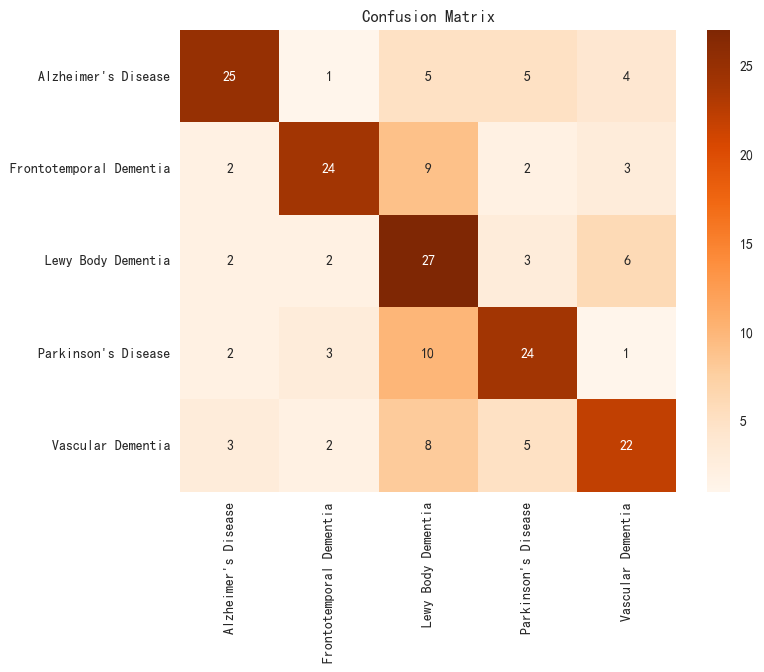

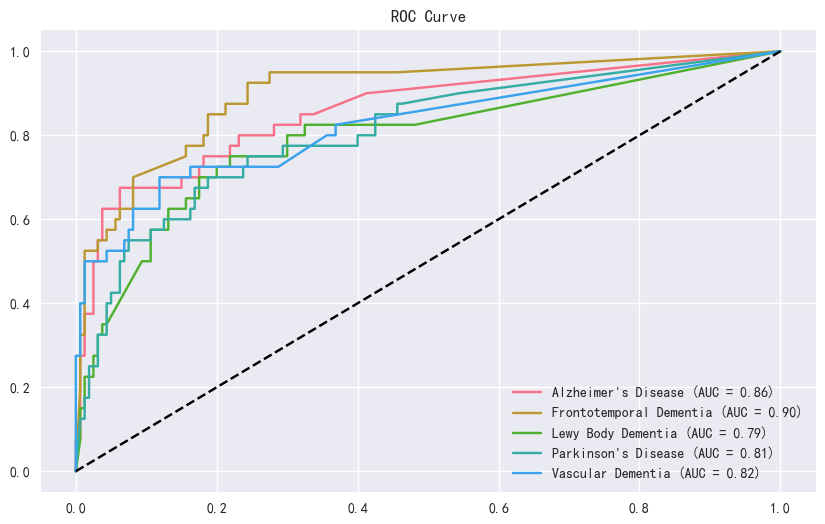


Step 6: Error Analysis...
Top Words in Errors: [('pad', np.int64(997)), ('disease', np.int64(377)), ('patient', np.int64(47)), ('study', np.int64(46)), ('brain', np.int64(37)), ('cognitive', np.int64(28)), ('diagnosis', np.int64(27)), ('year', np.int64(26)), ('method', np.int64(24)), ('neurodegenerative', np.int64(22)), ('age', np.int64(21)), ('clinical', np.int64(20)), ('change', np.int64(18)), ('using', np.int64(18)), ('data', np.int64(16)), ('amyloid', np.int64(15)), ('including', np.int64(15)), ('related', np.int64(14)), ('available', np.int64(13)), ('protein', np.int64(13))]

Step 7: SHAP Analysis (Linear Weights)...
SHAP Summary Plot


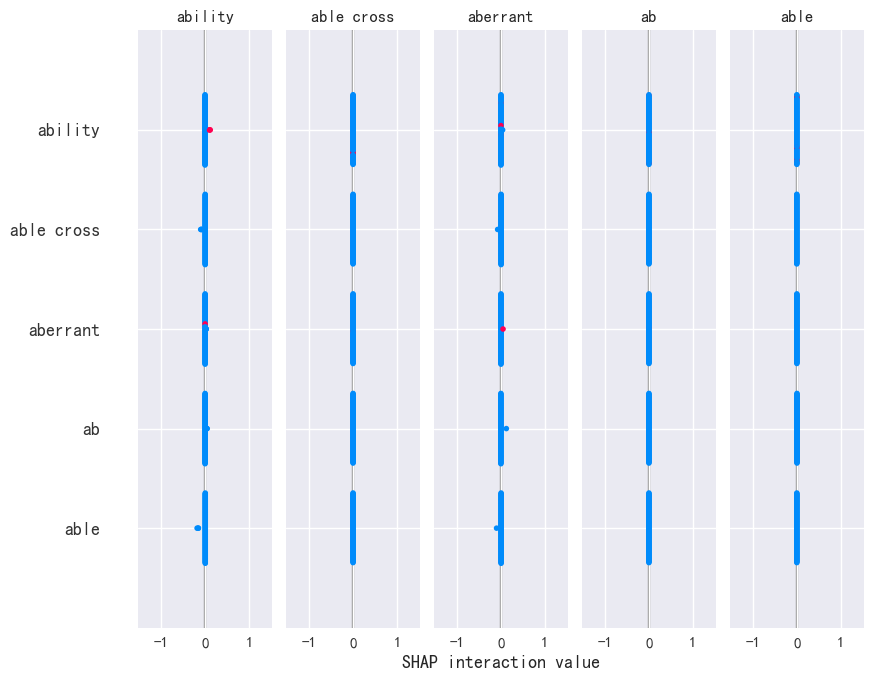

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import shap
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 数据加载与预处理
# ==========================================
print("Step 1: Loading Data...")
try:
    df = pd.read_csv('../cleaned_data.csv')
except:
    df = pd.read_csv('cleaned_data.csv')

df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])
label_names = le.classes_
print(f"Classes: {label_names}")

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label_Encoded'], 
    test_size=0.2, random_state=42, stratify=df['Label_Encoded']
)

# ==========================================
# 2. 特征工程: TF-IDF
# ==========================================
print("Step 2: Extracting TF-IDF Features...")
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

X_train_features = vectorizer.fit_transform(X_train_raw)
X_test_features = vectorizer.transform(X_test_raw)
feature_names = vectorizer.get_feature_names_out()

print(f"Feature Matrix Shape: {X_train_features.shape}")

# ==========================================
# 3. 模型训练: SGD (Linear Model)
# ==========================================
print("\nStep 3: Training SGD Classifier...")
# use loss='modified_huber' for probability outputs (predict_proba) required for ROC/metrics
# loss='hinge' is standard SVM but no probabilities
sgd_model = SGDClassifier(loss='modified_huber', random_state=42, n_jobs=-1)

print("Running 10-Fold Cross-Validation...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(sgd_model, X_train_features, y_train, cv=cv, scoring='accuracy')

print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

sgd_model.fit(X_train_features, y_train)

# ==========================================
# 4. 学习曲线
# ==========================================
print("\nStep 4: Plotting Learning Curves...")
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(sgd_model, "Learning Curve (TF-IDF + SGD)", X_train_features, y_train, cv=cv, n_jobs=-1)

# ==========================================
# 5. 评估与可视化
# ==========================================
y_pred = sgd_model.predict(X_test_features)
y_prob = sgd_model.predict_proba(X_test_features)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=label_names))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 6))
y_test_bin = pd.get_dummies(y_test).values
if y_test_bin.shape[1] == len(label_names):
    for i, class_label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# ==========================================
# 6. 误差分析
# ==========================================
print("\nStep 6: Error Analysis...")
misclassified_indices = np.where(y_test != y_pred)[0]
# ... Standard Code ...
if len(misclassified_indices) > 0:
    error_docs = X_test_raw.iloc[misclassified_indices]
    from sklearn.feature_extraction.text import CountVectorizer
    error_cv = CountVectorizer(stop_words='english', max_features=20)
    try:
        error_counts = error_cv.fit_transform(error_docs)
        error_words = error_cv.get_feature_names_out()
        error_word_freq = np.asarray(error_counts.sum(axis=0)).flatten()
        print(f"Top Words in Errors: {sorted(dict(zip(error_words, error_word_freq)).items(), key=lambda x: x[1], reverse=True)}")
    except: pass

# ==========================================
# 7. 可解释性 SHAP
# ==========================================
print("\nStep 7: SHAP Analysis (Linear Weights)...")
try:
    sample_train = shap.sample(X_train_features, 100)
    explainer = shap.LinearExplainer(sgd_model, sample_train, feature_perturbation="interventional")
    sample_test = X_test_features[:100].toarray()
    shap_values = explainer.shap_values(sample_test)
    
    print("SHAP Summary Plot")
    shap.summary_plot(shap_values, sample_test, feature_names=feature_names, show=False)
    plt.show()
except Exception as e:
    print(f"SHAP skipped: {e}")